In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-07-01 14:36:21.443881


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 32
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(0.3515)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-6.6592)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(73.4488)
train_loss:  -5.4596713616848
valid_loss:  -4.510964635920525
h_min_tilde -6.1621227 ell_tilde -5.269930016531943 kappa_tilde 0.0010586945193906824
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -1.4724192003011702
valid_loss:  -0.3583036919593811
weight_alpha 1.0 h_min_tilde -6.1621227 ell_tilde -1.2495960986328123 kappa_tilde 0.00045117761201078177


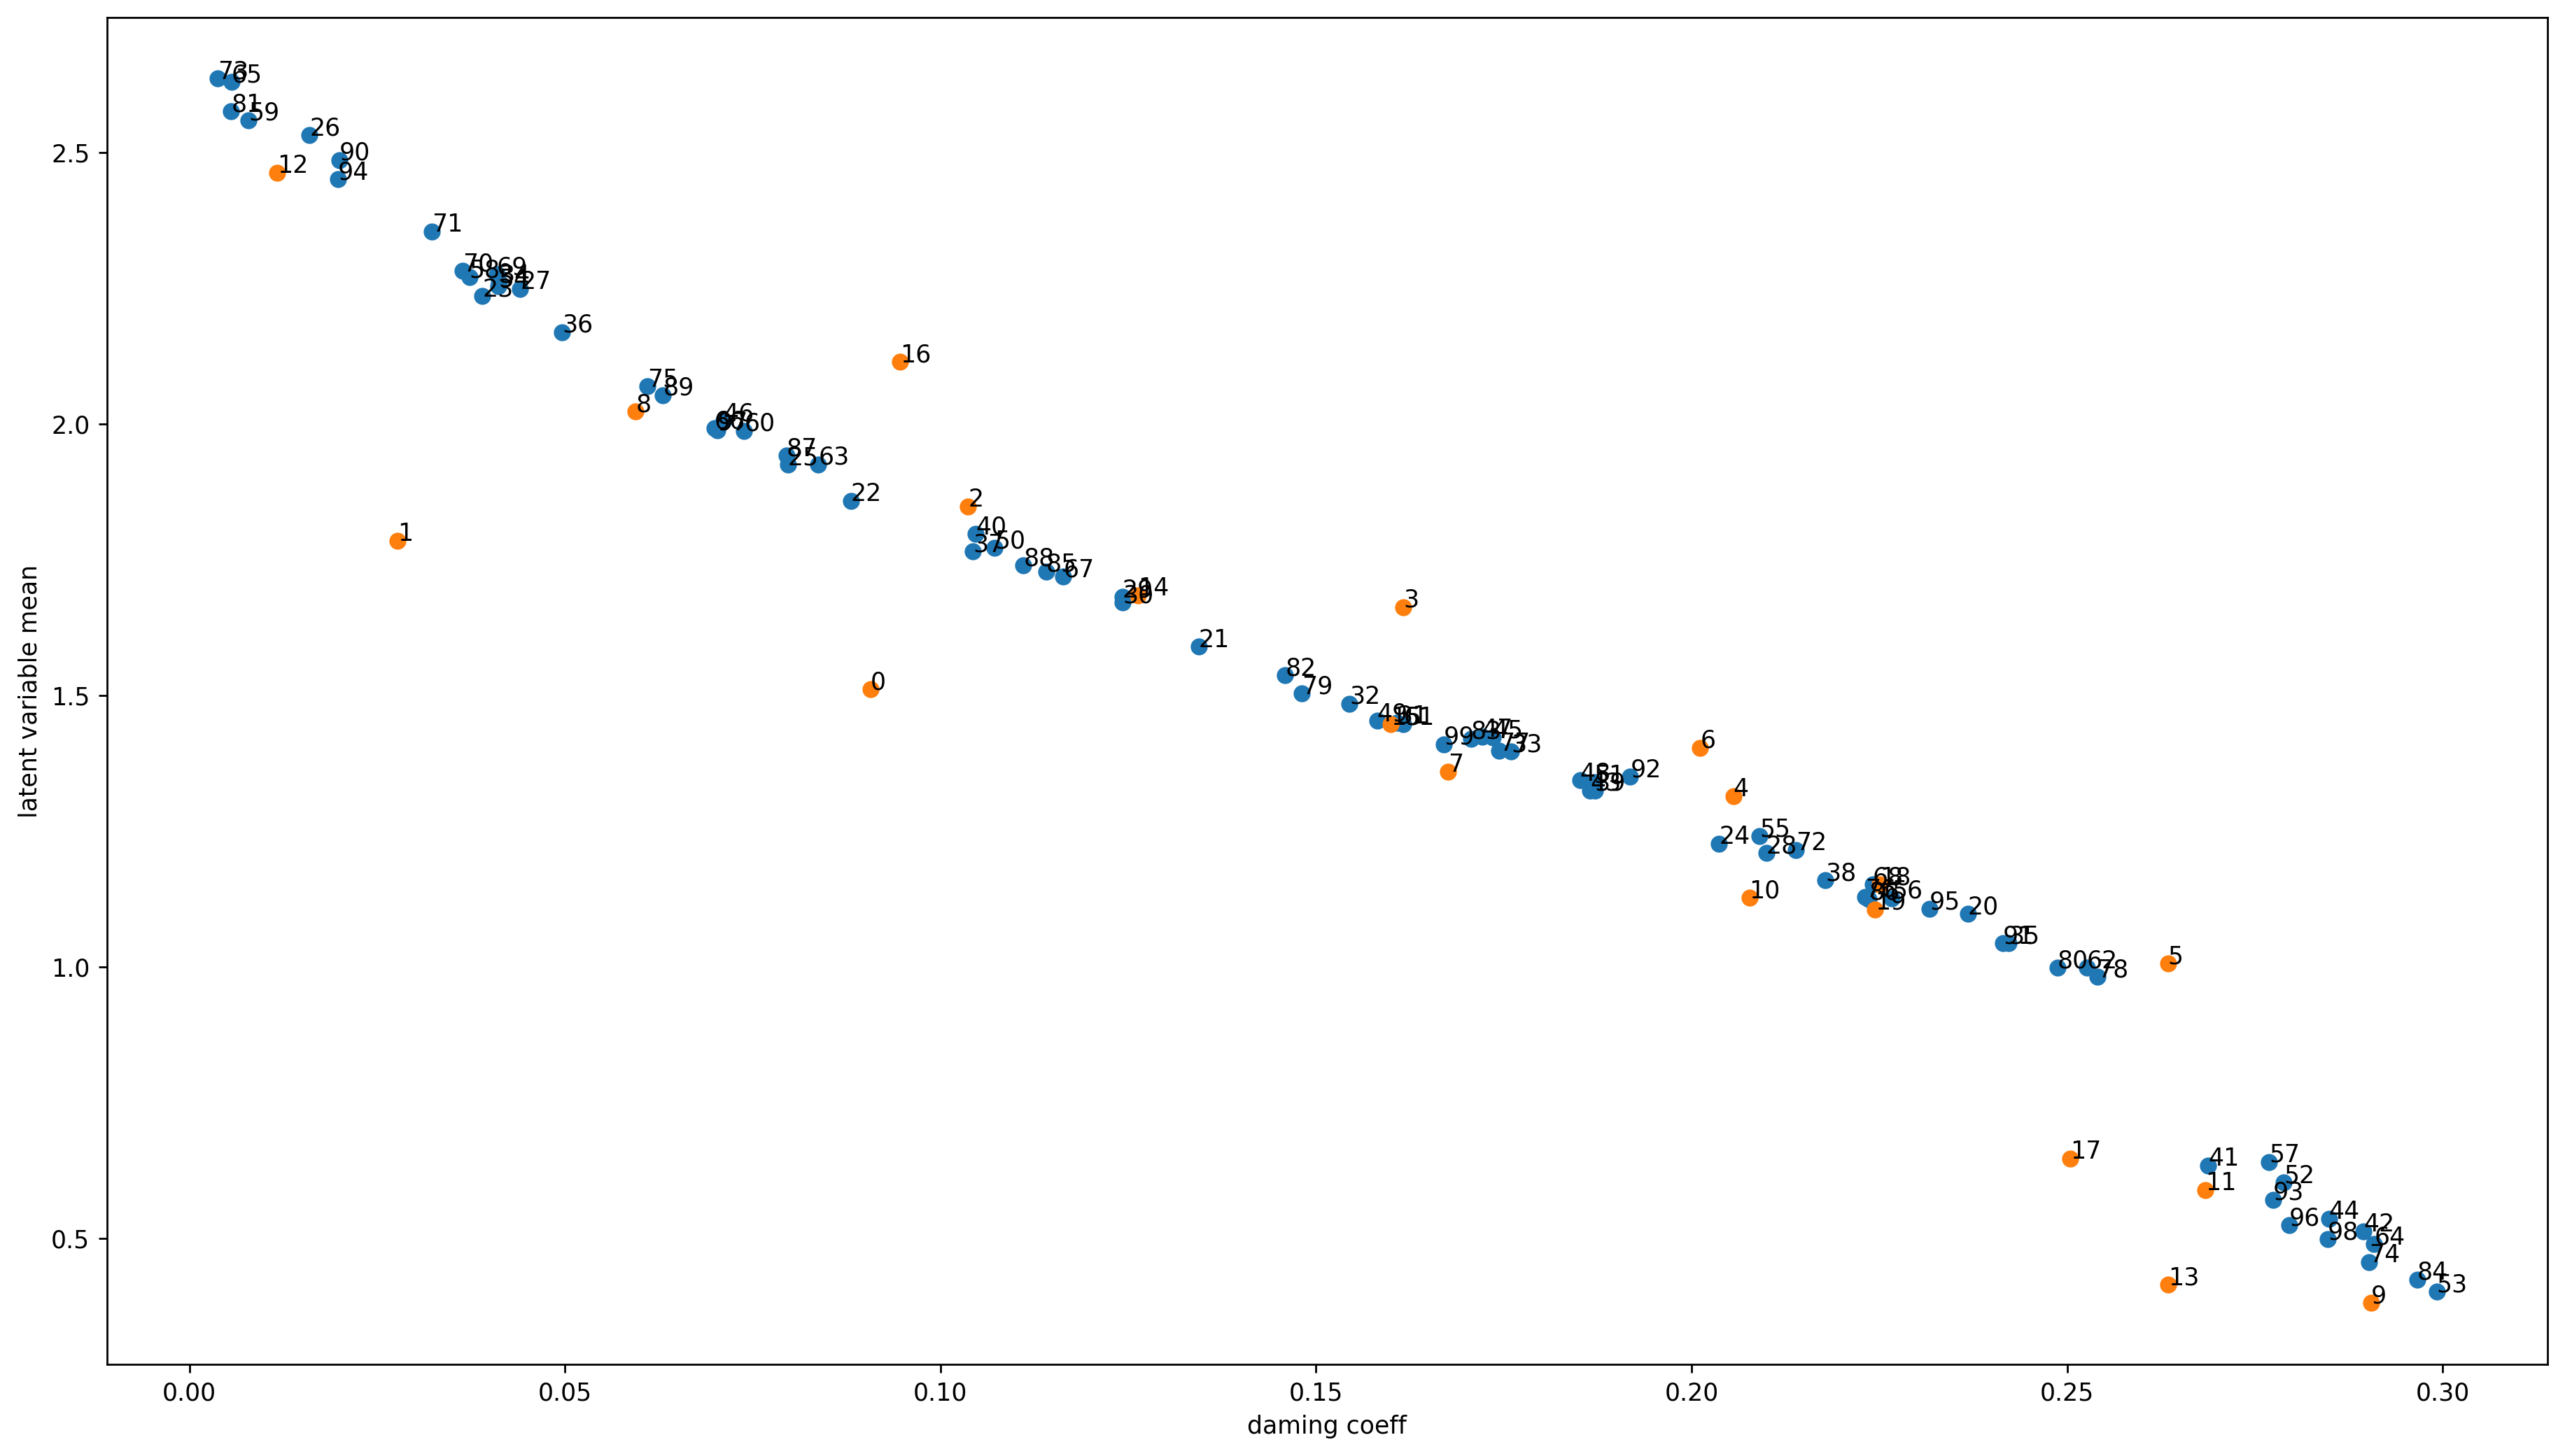

[0.09069977 0.02770158 0.10366822 0.16164502 0.20556585 0.26343523
 0.20114025 0.16760695 0.05943045 0.29047847]
[0.20769678 0.268382   0.01171643 0.26344275 0.12633229 0.15994959
 0.09465469 0.2503877  0.22504329 0.2244497 ]
[0.2367838  0.13436806 0.08808424 0.03900857 0.20365066 0.079664
 0.01600876 0.04401857 0.20992751 0.1242168 ]
[0.12425378 0.16076892 0.15446673 0.17596651 0.04124241 0.24221739
 0.04960626 0.10432976 0.2177994  0.18710166]
[0.1046695  0.26876587 0.28945201 0.18650872 0.28484678 0.17351688
 0.07110809 0.17210385 0.18514347 0.15811743]
[0.10718093 0.18700803 0.27883117 0.29919686 0.04114072 0.20904545
 0.22663892 0.27690736 0.03728129 0.0078633 ]
[0.07386332 0.16164932 0.25260927 0.0837551  0.29087872 0.00559419
 0.06989228 0.11635819 0.22413649 0.04093657]
[0.03640304 0.03224824 0.21389669 0.00376679 0.2901829  0.06098797
 0.22314776 0.17440768 0.25404864 0.14813091]
[0.24869427 0.00557286 0.14590353 0.17065543 0.29658485 0.11404235
 0.22360033 0.07947587 0.111025

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 4.1711955070495605

 2 3.7063705921173096

 3 3.599954128265381

 4 3.706469774246216

 5 7.002207517623901

 6 7.22722864151001

 7 7.446001768112183

 8 7.206299066543579

 9 7.313105583190918

 10 7.308007717132568

 11 3.7010228633880615

 12 7.5846452713012695

 13 7.672013998031616

 14 7.442025899887085

 15 7.504796028137207

 16 7.477522373199463

 17 7.784315824508667

 18 3.743783473968506

 19 3.667635917663574

 20 3.6699488162994385

 21 3.728644371032715

 22 3.557999610900879

 23 3.791438341140747

 24 3.7939183712005615

 25 3.72994065284729

 26 3.6095352172851562

 27 3.799053192138672

 28 3.87203311920166

 29 3.7519822120666504

 30 3.6926236152648926

 31 3.759050130844116

 32 3.7124555110931396

 33 3.712536334991455

 34 3.7002639770507812

 35 3.928705930709839

 36 3.747671365737915

 37 3.828258752822876

 38 3.7642619609832764

 39 3.8112852573394775

 40 3.670339345932007

 41 3.7914042472839355

 42 3.7871222496032715

 43 3.746577501296997

 44 3.7

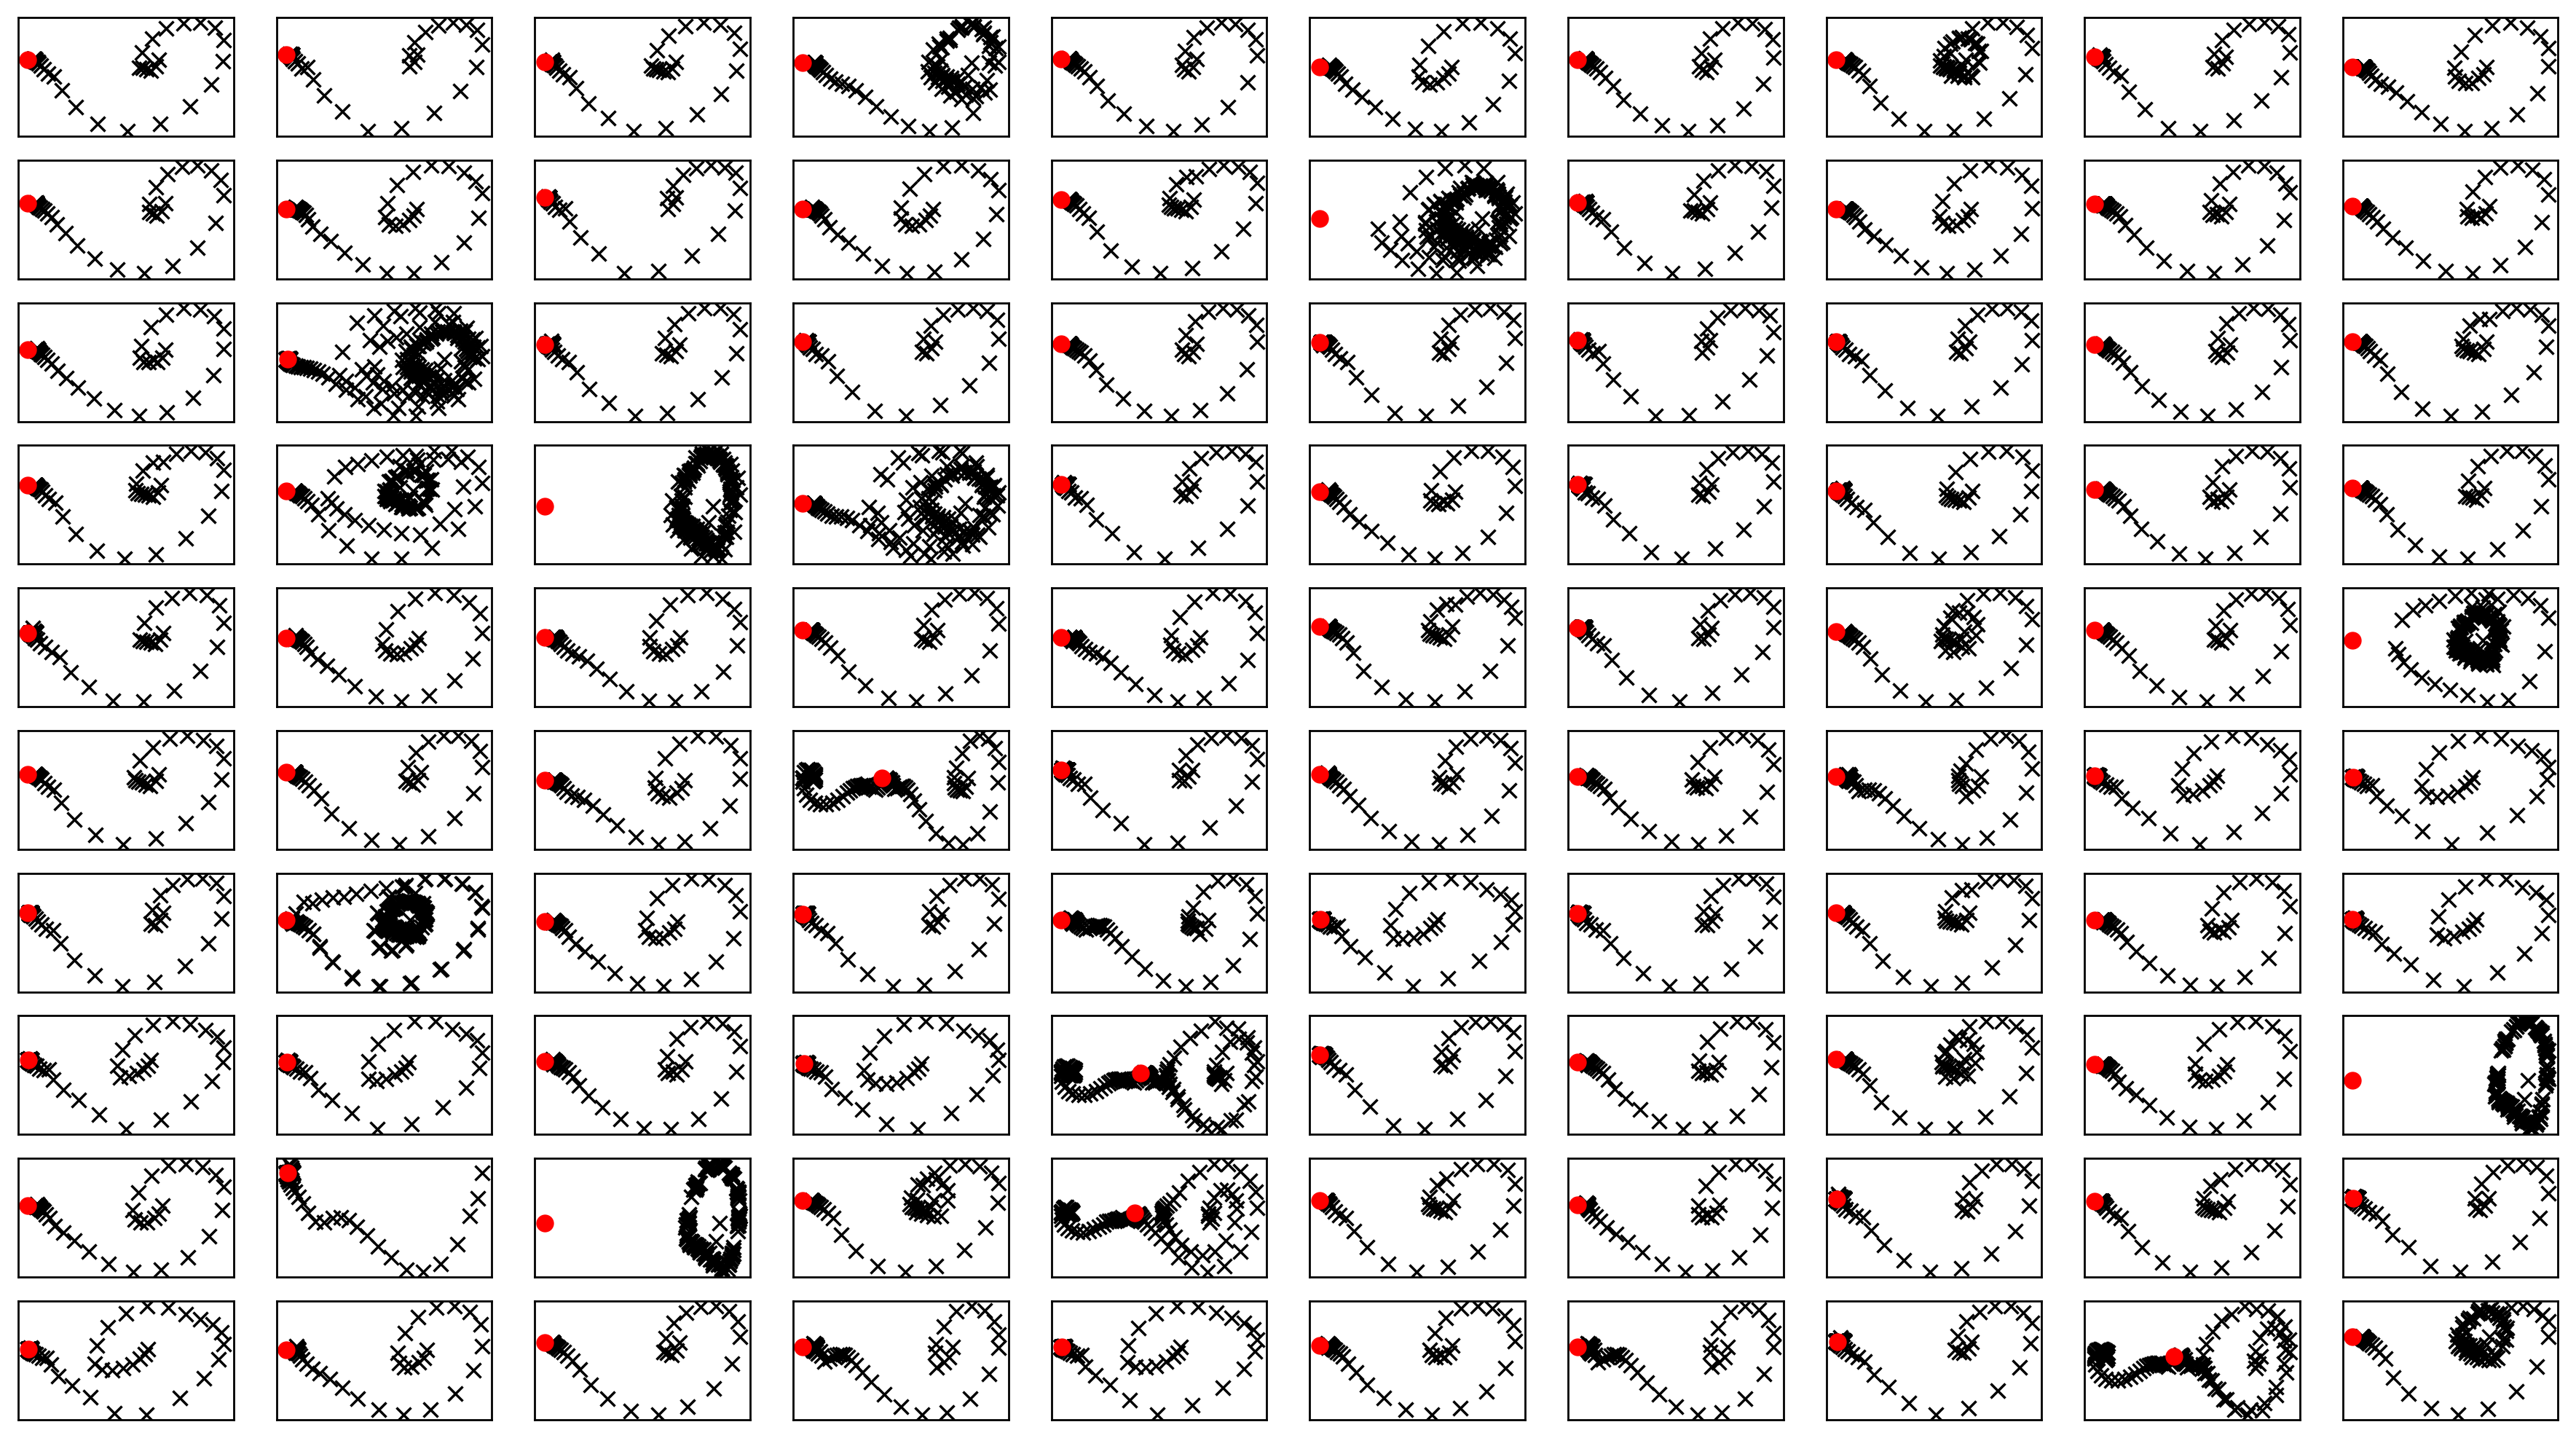

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.8293395042419434

 2 4.143252372741699

 3 3.993267059326172

 4 3.907956123352051

 5 3.9154787063598633

 6 3.9328649044036865

 7 3.839371681213379

 8 3.8697681427001953

 9 3.8938305377960205

 10 3.9934275150299072

 11 3.924938201904297

 12 4.150398254394531

 13 3.9571692943573

 14 3.8856072425842285

 15 3.9106578826904297

 16 3.9388201236724854

 17 3.8869948387145996

 18 3.911240339279175

 19 3.9046878814697266

 20 3.970242738723755

 21 3.8694112300872803

 22 4.188734531402588

 23 4.025820016860962

 24 4.014818429946899

 25 3.9928689002990723

 26 3.865419626235962

 27 3.9955506324768066

 28 3.806553602218628

 29 3.878274917602539

 30 3.965393304824829

 31 3.913135528564453

 32 3.8870298862457275

 33 3.7902638912200928

 34 4.002562761306763

 35 4.000024795532227

 36 3.9492008686065674

 37 4.007763624191284

 38 3.8115780353546143

 39 3.920576810836792

 40 3.927090644836426

 41 3.8502047061920166

 42 3.7232446670532227


In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())